In [10]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline
import sys
print(sys.version)


from qiskit import pulse, QuantumCircuit, QuantumRegister, ClassicalRegister#, IBMQ

from qiskit_ibm_runtime import QiskitRuntimeService

#from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional

# TOKEN = "736132e9a8be5a41142d2718a6934f3d30bd352712cae914ce51a91fde3cc2c9940f481a063bc109932ed8235fef5a353099173a347edaf56b9dc49c8c844add"

# Save an IBM Cloud account on disk
# QiskitRuntimeService.save_account(channel="ibm_quantum", token=TOKEN, overwrite=True)

# Run previous line with the appropriate token
# service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)
service = QiskitRuntimeService()
print(service)

3.9.11 (v3.9.11:2de452f8bf, Mar 16 2022, 10:34:36) 
[Clang 6.0 (clang-600.0.57)]


<QiskitRuntimeService>


In [11]:
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# provider.backends()
### KYOTO DETAILS ###
backend = service.backend('ibm_kyoto') # replace the name with the exact one for the backend that is desired from the previous displayed backends
qubit = 2
print(backend)

<IBMBackend('ibm_kyoto')>


In [12]:
DEBUG_PRINT = True

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 2
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

config: <qiskit.providers.models.backendconfiguration.PulseBackendConfiguration object at 0x7fa310860b80>
backend_name
ibm_kyoto
backend_version
1.2.40
n_qubits
127
basis_gates
['ecr', 'id', 'rz', 'sx', 'x']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], [114

## Acquisition Scan Analysis
1. Rectangular vs Gaussian Square
2. Varying Amps Rectangular
3. Full Gaussian, varying amplitudes (sufficient std)

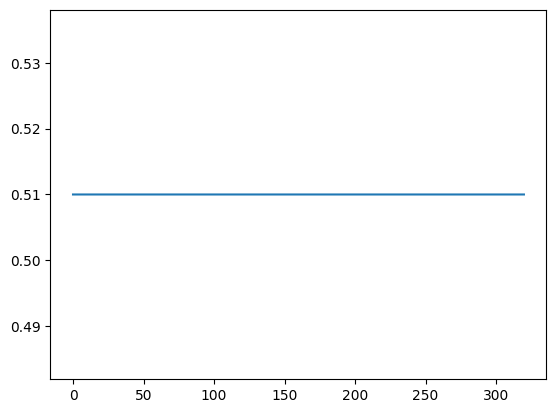

In [13]:
from utils import convert_arr_to_dt, get_dt_from

cal_tau_1 = 75 * ns
cal_tau_2 = 450 * ns
long_tau_3 = 200.0 * ns

meas_pulse_dur_dt = get_dt_from(cal_tau_2 + long_tau_3 + 40. * ns)

flat_meas_pulse = np.ones(measure_pulse.duration) * measure_pulse.amp

plt.plot(np.arange(measure_pulse.duration) / 4.5, flat_meas_pulse)

In [14]:
acq_start_dt = get_dt_from(0. * ns, dt)
acq_end_dt = get_dt_from(1400. * ns, dt)
meas_pulse_dur_dt = (acq_end_dt - acq_start_dt)
num_acq_exp = 57
acq_delay_linspace = np.linspace(acq_start_dt, acq_end_dt, num_acq_exp) * dt
acq_delay_linspace_us = convert_arr_to_dt(acq_delay_linspace)

acq_latency_dt = get_dt_from(750 * ns, dt)
acq_dur_dt = get_dt_from(10.6 * ns, dt)

print(acq_dur_dt*dt/ns)
print(acq_delay_linspace_us/ns)
print(np.diff(acq_delay_linspace_us) / ns)

8.0
[   0.           24.88888889   49.77777778   74.66666667   99.55555556
  124.44444444  149.33333333  174.22222222  199.11111111  224.
  248.88888889  273.77777778  298.66666667  323.55555556  348.44444444
  373.33333333  401.77777778  426.66666667  451.55555556  476.44444444
  501.33333333  526.22222222  551.11111111  576.          600.88888889
  625.77777778  650.66666667  675.55555556  700.44444444  725.33333333
  750.22222222  775.11111111  800.          824.88888889  849.77777778
  874.66666667  899.55555556  924.44444444  949.33333333  974.22222222
  999.11111111 1024.         1048.88888889 1073.77777778 1098.66666667
 1123.55555556 1148.44444444 1173.33333333 1201.77777778 1226.66666667
 1251.55555556 1276.44444444 1301.33333333 1326.22222222 1351.11111111
 1376.         1400.88888889]
[24.88888889 24.88888889 24.88888889 24.88888889 24.88888889 24.88888889
 24.88888889 24.88888889 24.88888889 24.88888889 24.88888889 24.88888889
 24.88888889 24.88888889 24.88888889 28.4444444

114
114
114
114


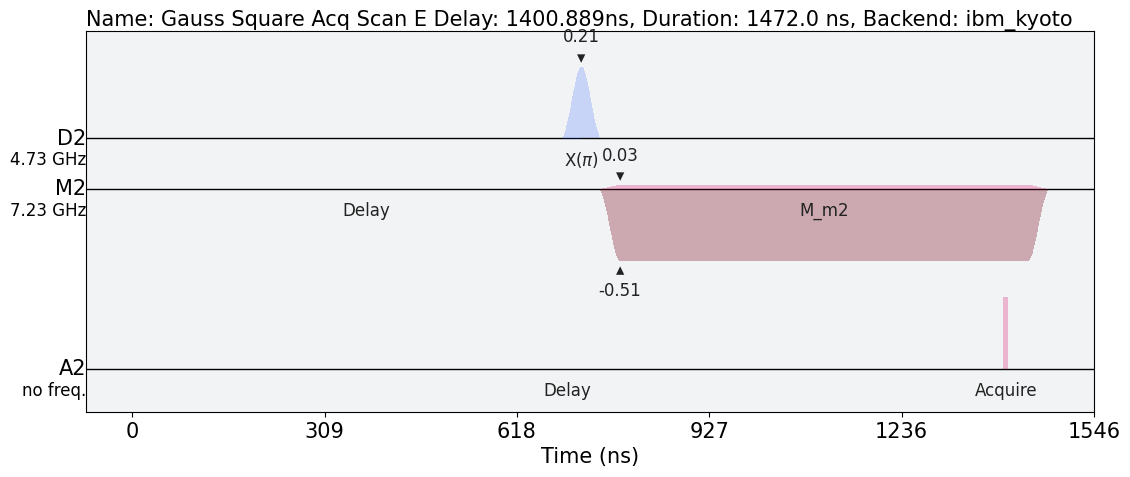

In [18]:
# Making Experiments

standard_exps_g = []
standard_exp_g_circs = []
standard_exps_e = []
standard_exp_e_circs = []

for acq_delay_us in acq_delay_linspace_us:
    acq_delay_dt = get_dt_from(acq_delay_us, dt)
    acq_delay_ns = np.round(acq_delay_us/ns, 3)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Flat Meas Acq Scan G Delay: {acq_delay_ns}ns',
    ) as flat_sched_g:
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        pulse.delay(acq_latency_dt, meas_chan)
        pulse.play(flat_meas_pulse, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            acq_dur_dt,
            qubit,
            pulse.MemorySlot(qubit),
        )
    standard_exps_g.append(flat_sched_g)
    circ = QuantumCircuit(3,3)
    circ.measure(2,2)
    circ.add_calibration('measure', [2], flat_sched_g)
    standard_exp_g_circs.append(circ)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Flat Meas Acq Scan E Delay: {acq_delay_ns}ns',
    ) as flat_sched_e:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        with pulse.align_right():
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(acq_latency_dt, meas_chan)
        pulse.play(flat_meas_pulse, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            acq_dur_dt,
            qubit,
            pulse.MemorySlot(qubit),
        )
    standard_exps_e.append(flat_sched_e)
    circ = QuantumCircuit(3,3)
    circ.measure(2,2)
    circ.add_calibration('measure', [2], flat_sched_e)
    standard_exp_e_circs.append(circ)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Gauss Square Acq Scan G Delay: {acq_delay_ns}ns',
    ) as gauss_sched_g:
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        pulse.delay(acq_latency_dt, meas_chan)
        pulse.play(measure_pulse, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            acq_dur_dt,
            qubit,
            pulse.MemorySlot(qubit),
        )
    standard_exps_g.append(gauss_sched_g)
    circ = QuantumCircuit(3,3)
    circ.measure(2,2)
    circ.add_calibration('measure', [2], gauss_sched_g)
    standard_exp_g_circs.append(circ)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Gauss Square Acq Scan E Delay: {acq_delay_ns}ns',
    ) as gauss_sched_e:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        with pulse.align_right():
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(acq_latency_dt, meas_chan)
        pulse.play(measure_pulse, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            acq_dur_dt,
            qubit,
            pulse.MemorySlot(qubit),
        )
    standard_exps_e.append(gauss_sched_e)
    circ = QuantumCircuit(3,3)
    circ.measure(2,2)
    circ.add_calibration('measure', [2], gauss_sched_e)
    standard_exp_e_circs.append(circ)

print(len(standard_exps_g))
print(len(standard_exps_e))
print(len(standard_exp_g_circs))
print(len(standard_exp_e_circs))

standard_exps_e[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [19]:
standard_exp_e_circs[-1].draw()

q_0: ───
        
q_1: ───
     ┌─┐
q_2: ┤M├
     └╥┘
c: 3/═╩═
      2

In [20]:
# Varying Amps Rectangular

amps_linspace = np.array([
    measure_pulse.amp, 
    measure_pulse.amp + 0.15,
    measure_pulse.amp + 0.30
])

amp_acq_start_dt = get_dt_from(0. * ns, dt)
amp_acq_end_dt = get_dt_from(700 * ns, dt)
amp_meas_pulse_dur_dt = (amp_acq_end_dt - amp_acq_start_dt)
amp_num_acq_exp = 34
amp_acq_delay_linspace = np.linspace(amp_acq_start_dt, amp_acq_end_dt, amp_num_acq_exp) * dt
amp_acq_delay_linspace_us = convert_arr_to_dt(amp_acq_delay_linspace)

102
102
102
102


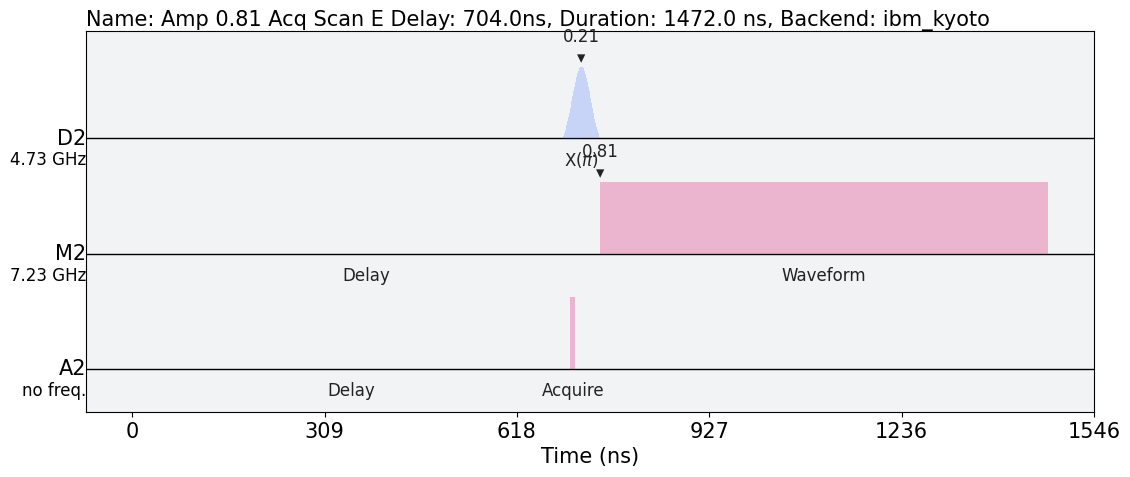

In [21]:
# Making Experiments

amp_exps_g = []
amp_exp_g_circs = []
amp_exps_e = []
amp_exp_e_circs = []

for amp in amps_linspace:
    m_pulse = np.ones(measure_pulse.duration) * amp
    for acq_delay_us in amp_acq_delay_linspace_us:
        acq_delay_dt = get_dt_from(acq_delay_us, dt)
        acq_delay_ns = np.round(acq_delay_us/ns, 3)

        with pulse.build(
            backend=backend,
            default_alignment='left',
            name=f'Amp {amp} Acq Scan G Delay: {acq_delay_ns}ns',
        ) as amp_sched_g:
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            pulse.delay(acq_latency_dt, meas_chan)
            pulse.play(m_pulse, meas_chan)
            pulse.delay(acq_delay_dt, acq_chan)
            pulse.acquire(
                acq_dur_dt,
                qubit,
                pulse.MemorySlot(qubit),
            )
        amp_exps_g.append(amp_sched_g)
        circ = QuantumCircuit(3,3)
        circ.measure(2,2)
        circ.add_calibration('measure', [2], amp_sched_g)
        amp_exp_g_circs.append(circ)

        with pulse.build(
            backend=backend,
            default_alignment='left',
            name=f'Amp {amp} Acq Scan E Delay: {acq_delay_ns}ns',
        ) as amp_sched_e:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            with pulse.align_right():
                pulse.play(x_pulse, qubit_chan)
                pulse.delay(acq_latency_dt, meas_chan)
            pulse.play(m_pulse, meas_chan)
            pulse.delay(acq_delay_dt, acq_chan)
            pulse.acquire(
                acq_dur_dt,
                qubit,
                pulse.MemorySlot(qubit),
            )
        amp_exps_e.append(amp_sched_e)
        circ = QuantumCircuit(3,3)
        circ.measure(2,2)
        circ.add_calibration('measure', [2], amp_sched_e)
        amp_exp_e_circs.append(circ)

print(len(amp_exps_g))
print(len(amp_exps_e))
print(len(amp_exp_g_circs))
print(len(amp_exp_e_circs))

amp_exps_e[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [22]:
amp_exp_e_circs[-1].draw()

q_0: ───
        
q_1: ───
     ┌─┐
q_2: ┤M├
     └╥┘
c: 3/═╩═
      2

In [26]:
from utils import acquisition_checker

batch_1 = standard_exps_g + standard_exps_e
batch_2 = amp_exps_g + amp_exps_e
batch_1_circ = standard_exp_g_circs + standard_exp_e_circs
batch_2_circ = amp_exp_g_circs + amp_exp_e_circs

print(len(batch_1_circ))
print(len(batch_2_circ))

acquisition_checker(batch_1, backend)
acquisition_checker(batch_2, backend)

num_shots = 4096
rep_delay = 10.0 * us

228
204


In [27]:
# Running total_job

job_experiment = backend.run(batch_1_circ, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay,
                            init_qubits=True)

print(job_experiment)

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_54670/863620186.py:3: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job_experiment = backend.run(batch_1_circ,


<RuntimeJob('ctwe608v0kkg008q00f0', 'circuit-runner')>


In [28]:
job_experiment_2 = backend.run(batch_2_circ, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay,
                            init_qubits=True)

print(job_experiment_2)

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_54670/1505513046.py:1: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job_experiment_2 = backend.run(batch_2_circ,


<RuntimeJob('ctwe68sv0kkg008q00fg', 'circuit-runner')>


In [29]:
job_0 = service.job('ctwe608v0kkg008q00f0')
job_1 = service.job('ctwe68sv0kkg008q00fg')

In [30]:
results_1 = job_0.result()
results_2 = job_1.result()

In [31]:
results_1_data = results_1.to_dict()
results_2_data = results_2.to_dict()

In [32]:
actual_results_1 = results_1_data["results"]
actual_results_2 = results_2_data["results"]

In [34]:
big_list_res_1 = []

for res_obj in actual_results_1:
    temp = res_obj["data"]["memory"]
    temp = np.array(temp) * scale_factor
    temp = temp.squeeze()
    big_list_res_1.append(temp)

big_array_res_1 = np.array(big_list_res_1)

big_list_res_2 = []

for res_obj in actual_results_2:
    temp = res_obj["data"]["memory"]
    temp = np.array(temp) * scale_factor
    temp = temp.squeeze()
    big_list_res_2.append(temp)

big_array_res_2 = np.array(big_list_res_2)

print(big_array_res_1.shape)
print(big_array_res_2.shape)

(228, 4096, 3, 2)
(204, 4096, 3, 2)


In [39]:
big_array_res_1_complex = big_array_res_1[:,:,2,0] + 1.0j * big_array_res_1[:,:,2,1]
big_array_res_2_complex = big_array_res_2[:,:,2,0] + 1.0j * big_array_res_2[:,:,2,1]

In [60]:
# Processing first batch of results

res_1_reshaped = big_array_res_1_complex.reshape(-1, 4, num_shots)
res_1_reshaped = np.swapaxes(res_1_reshaped, 0, 1)

flat_res_g = res_1_reshaped[0]
flat_res_e = res_1_reshaped[1]
gauss_square_res_g = res_1_reshaped[2]
gauss_square_res_e = res_1_reshaped[3]

In [61]:
# Measure Fidelities of G/E by themselves
import copy
from utils import get_fidelity

flat_fidelity, flat_sep_fidelity = get_fidelity(copy.deepcopy(flat_res_g), copy.deepcopy(flat_res_e))
print(flat_fidelity.shape)
print(flat_sep_fidelity.shape)

gauss_square_fidelity, gauss_square_sep_fidelity = get_fidelity(copy.deepcopy(gauss_square_res_g), copy.deepcopy(gauss_square_res_e))
print(gauss_square_fidelity.shape)
print(gauss_square_sep_fidelity.shape)

(57,)
(57,)
(57,)
(57,)


In [62]:
print(np.max(flat_fidelity))
print(np.max(flat_sep_fidelity))

print(np.max(gauss_square_fidelity))
print(np.max(gauss_square_sep_fidelity))

0.9931640625
0.9994847448845925
0.9932861328125
0.9993421084099425


In [63]:
flat_pf = -np.log10(1. - flat_fidelity)
flat_sep_pf = -np.log10(1. - flat_sep_fidelity)

gauss_square_pf = -np.log10(1. - gauss_square_fidelity)
gauss_square_sep_pf = -np.log10(1. - gauss_square_sep_fidelity)

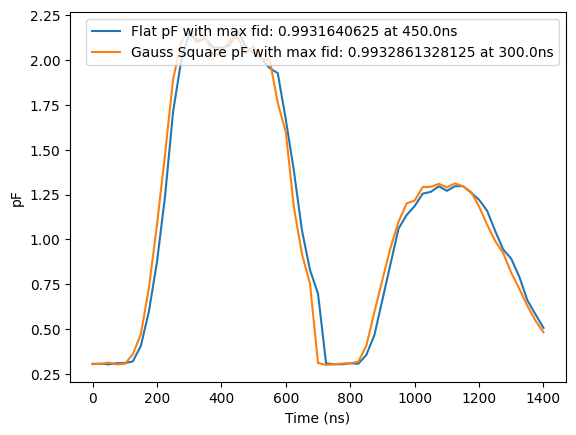

In [65]:
plt.plot(acq_delay_linspace/ns, flat_pf, label=f'Flat pF with max fid: {np.max(flat_fidelity)} at {acq_delay_linspace[np.argmax(flat_fidelity)]/ns}ns')
# plt.plot(acq_delay_linspace/ns, flat_sep_pf, label=f'Flat sep pF')
plt.plot(acq_delay_linspace/ns, gauss_square_pf, label=f'Gauss Square pF with max fid: {np.max(gauss_square_fidelity)} at {acq_delay_linspace[np.argmax(gauss_square_fidelity)]/ns}ns')
# plt.plot(acq_delay_linspace/ns, gauss_square_sep_pf, label=f'Flat sep pF')
plt.xlabel('Time (ns)')
plt.ylabel('pF')
plt.legend()
plt.show()

In [66]:
flat_mean_g = np.mean(flat_res_g, axis=1)
flat_mean_e = np.mean(flat_res_e, axis=1)

flat_angle = 0.5 * (np.unwrap(np.angle(flat_mean_g)) + np.unwrap(np.angle(flat_mean_e))) - 0.5 * np.pi
flat_rot_g = flat_mean_g * np.exp(-1.0j * flat_angle)
flat_rot_e = flat_mean_e * np.exp(-1.0j * flat_angle)

print(flat_rot_g.shape)

(57,)


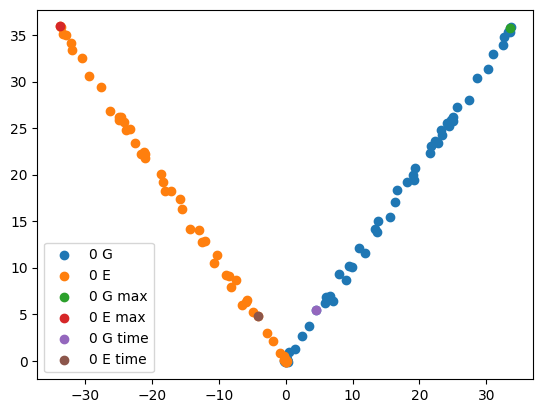

In [78]:
scale_factor = 1.0

flat_time_ns = 1400.0

plt.scatter(flat_rot_g.real, flat_rot_g.imag * scale_factor, label='0 G')
plt.scatter(flat_rot_e.real, flat_rot_e.imag * scale_factor, label='0 E')
plt.scatter(flat_rot_g[np.argmax(flat_fidelity)].real, flat_rot_g[np.argmax(flat_fidelity)].imag * scale_factor, label='0 G max')
plt.scatter(flat_rot_e[np.argmax(flat_fidelity)].real, flat_rot_e[np.argmax(flat_fidelity)].imag * scale_factor, label='0 E max') 
plt.scatter(flat_rot_g[np.argmin(np.abs(acq_delay_linspace/ns - flat_time_ns))].real, flat_rot_g[np.argmin(np.abs(acq_delay_linspace/ns - flat_time_ns))].imag * scale_factor, label='0 G time')
plt.scatter(flat_rot_e[np.argmin(np.abs(acq_delay_linspace/ns - flat_time_ns))].real, flat_rot_e[np.argmin(np.abs(acq_delay_linspace/ns - flat_time_ns))].imag * scale_factor, label='0 E time') 
plt.legend()
# plt.xlim(left=-10., right=10.)
plt.show()

In [79]:
gauss_square_mean_g = np.mean(gauss_square_res_g, axis=1)
gauss_square_mean_e = np.mean(gauss_square_res_e, axis=1)

gauss_square_angle = 0.5 * (np.unwrap(np.angle(gauss_square_mean_g)) + np.unwrap(np.angle(gauss_square_mean_e))) - 0.5 * np.pi
gauss_square_rot_g = gauss_square_mean_g * np.exp(-1.0j * gauss_square_angle)
gauss_square_rot_e = gauss_square_mean_e * np.exp(-1.0j * gauss_square_angle)

print(gauss_square_rot_g.shape)

(57,)


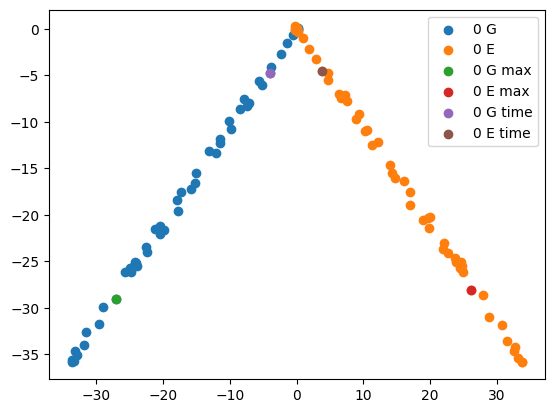

In [80]:
scale_factor = 1.0

gauss_square_time_ns = 1400.0

plt.scatter(gauss_square_rot_g.real, gauss_square_rot_g.imag * scale_factor, label='0 G')
plt.scatter(gauss_square_rot_e.real, gauss_square_rot_e.imag * scale_factor, label='0 E')
plt.scatter(gauss_square_rot_g[np.argmax(gauss_square_fidelity)].real, gauss_square_rot_g[np.argmax(gauss_square_fidelity)].imag * scale_factor, label='0 G max')
plt.scatter(gauss_square_rot_e[np.argmax(gauss_square_fidelity)].real, gauss_square_rot_e[np.argmax(gauss_square_fidelity)].imag * scale_factor, label='0 E max') 
plt.scatter(gauss_square_rot_g[np.argmin(np.abs(acq_delay_linspace/ns - gauss_square_time_ns))].real, gauss_square_rot_g[np.argmin(np.abs(acq_delay_linspace/ns - gauss_square_time_ns))].imag * scale_factor, label='0 G time')
plt.scatter(gauss_square_rot_e[np.argmin(np.abs(acq_delay_linspace/ns - gauss_square_time_ns))].real, gauss_square_rot_e[np.argmin(np.abs(acq_delay_linspace/ns - gauss_square_time_ns))].imag * scale_factor, label='0 E time') 
plt.legend()
# plt.xlim(left=-10., right=10.)
plt.show()

In [85]:
# Processing second batch of results

res_2_reshaped = big_array_res_2_complex.reshape(-1, 2, num_shots)
res_2_reshaped = np.swapaxes(res_2_reshaped, 0, 1)

amp_res_g = res_2_reshaped[0]
amp_res_e = res_2_reshaped[1]

amp_res_g.shape

(102, 4096)

In [95]:
# Measure Fidelities

amp_fidelity, amp_sep_fidelity = get_fidelity(copy.deepcopy(amp_res_g), copy.deepcopy(amp_res_e))

amp_fidelity = amp_fidelity.reshape(3, -1)
amp_sep_fidelity = amp_sep_fidelity.reshape(3, -1)

print(amp_fidelity.shape)
print(amp_sep_fidelity.shape)

(3, 34)
(3, 34)


In [96]:
print(np.max(amp_fidelity, axis=-1))
print(np.max(amp_sep_fidelity, axis=-1))

[0.99157715 0.99243164 0.98339844]
[0.99997469 0.99999499 0.98274896]


In [97]:
amp_pf = -np.log10(1. - amp_fidelity)
amp_sep_pf = -np.log10(1. - amp_sep_fidelity)

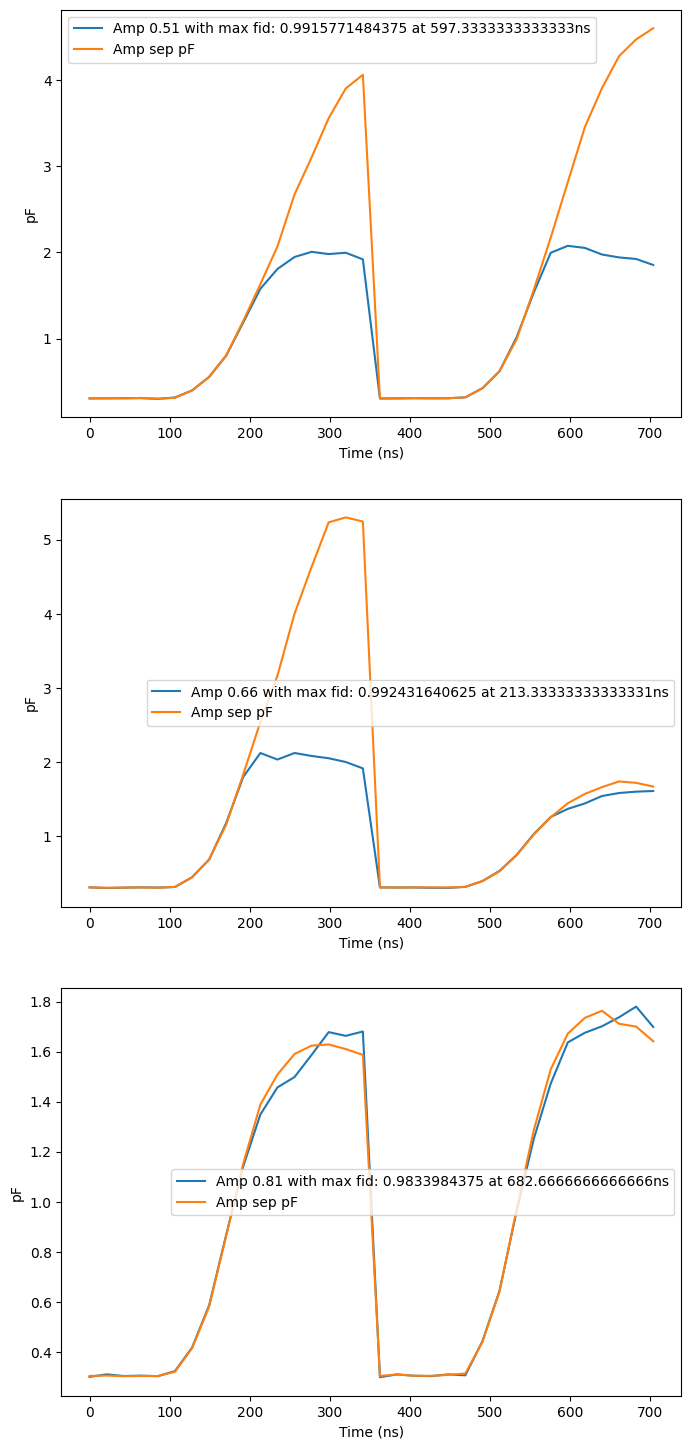

In [101]:
fig, ax = plt.subplots(3, figsize=(8.0, 6.0 * 3))

for i, a_pf in enumerate(amp_pf):
    ax[i].plot(amp_acq_delay_linspace/ns, a_pf, label=f'Amp {amps_linspace[i]} with max fid: {np.max(amp_fidelity[i])} at {amp_acq_delay_linspace[np.argmax(amp_fidelity[i])]/ns}ns')
    ax[i].plot(amp_acq_delay_linspace/ns, amp_sep_pf[i], label=f'Amp sep pF')
    ax[i].set_xlabel('Time (ns)')
    ax[i].set_ylabel('pF')
    ax[i].legend()
plt.show()

In [119]:
arr = np.arange(204)
batch_arr = np.tile(arr, (4096, 1)).T
batch_arr = batch_arr + np.arange(4096).reshape(1, -1) / 8192
print(batch_arr[2])

new_arr = batch_arr.reshape(-1, 2, 4096)
new_arr = np.swapaxes(new_arr, 0, 1)
print(new_arr[0, :, 1])

[2.         2.00012207 2.00024414 ... 2.49963379 2.49975586 2.49987793]
[1.22070312e-04 2.00012207e+00 4.00012207e+00 6.00012207e+00
 8.00012207e+00 1.00001221e+01 1.20001221e+01 1.40001221e+01
 1.60001221e+01 1.80001221e+01 2.00001221e+01 2.20001221e+01
 2.40001221e+01 2.60001221e+01 2.80001221e+01 3.00001221e+01
 3.20001221e+01 3.40001221e+01 3.60001221e+01 3.80001221e+01
 4.00001221e+01 4.20001221e+01 4.40001221e+01 4.60001221e+01
 4.80001221e+01 5.00001221e+01 5.20001221e+01 5.40001221e+01
 5.60001221e+01 5.80001221e+01 6.00001221e+01 6.20001221e+01
 6.40001221e+01 6.60001221e+01 6.80001221e+01 7.00001221e+01
 7.20001221e+01 7.40001221e+01 7.60001221e+01 7.80001221e+01
 8.00001221e+01 8.20001221e+01 8.40001221e+01 8.60001221e+01
 8.80001221e+01 9.00001221e+01 9.20001221e+01 9.40001221e+01
 9.60001221e+01 9.80001221e+01 1.00000122e+02 1.02000122e+02
 1.04000122e+02 1.06000122e+02 1.08000122e+02 1.10000122e+02
 1.12000122e+02 1.14000122e+02 1.16000122e+02 1.18000122e+02
 1.20000122e+

In [106]:
arr = np.arange(102)
arr = arr.reshape
print(arr.reshape(3, -1)[2])

[ 68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101]
